## Setup

### Importing Dependencies

In [1]:
# Data Loading
from datasets import load_dataset
import pandas as pd

# Torch for training models
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR

from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel # For obtaining GPT-2 embeddings

# Mathematical libraries
import numpy as np
import math
import cmath
import random
from scipy import stats
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD
from sklearn.utils import check_array
from sklearn.cluster import MiniBatchKMeans
import dcor

# Visualization and data saving
from tqdm import tqdm, trange
import os
import matplotlib.pyplot as plt
import umap
import pickle

# Utitlties
import copy
from collections import Counter
from functools import partial

### Fixing Random Seeds for Reproducibility

In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

### Making QLens Folder to Store Results

In [3]:
proj_dir = "QLens/" # Personalize if needed
os.makedirs(proj_dir, exist_ok=True)

## Dataset Preprocessing

### Compiling User Data

In [5]:
# Loading the Amazon Books Dataset files

# Item file
item_file = "Books.item"

# Interations file
inter_file = "Books.inter"

In [6]:
# Reading the interactions file
inter_df = pd.read_csv(f"{proj_dir}{inter_file}", sep='\t')

In [7]:
inter_df.head(3)

,user_id:token,item_id:token,rating:float,timestamp:float
0,A1C6M8LCIX4M6M,0001713353,5.0,1123804800
1,A1REUF3A1YCPHM,0001713353,5.0,1112140800
2,A1YRBRK2XM5D5,0001713353,5.0,1081036800


In [8]:
len(inter_df)

51311621

In [9]:
# Reading the item file
item_df = pd.read_csv(f"{proj_dir}{item_file}", sep='\t')

In [10]:
item_df.head(3)

,item_id:token,title:token,categories:token_seq,brand:token,sales_type:token,sales_rank:float
0,0000092878,Biology Gods Living Creation Third Edition 10 ...,NaN,Keith Graham,Books,1349781.0
1,000047715X,Mksap 16 Audio Companion: Medical Knowledge Se...,'Books',Acp,Books,1702625.0
2,0000004545,"Flex! Discography of North American Punk, Hard...","'Books', 'Music'",Burkhard Jarisch,Books,6291012.0


In [11]:
len(item_df)

3023135

In [12]:
# Filtering item file to only include the needed features and instances
item_df = item_df.loc[:, ['item_id:token', 'title:token']] # Only the item_id and title columns are needed

In [13]:
# Reducing dataset size to the top 50,000 users
TOP_N_USERS = 50000

# Normalizing user id strings (helps avoid subtle dupes)
inter_df['user_id:token'] = inter_df['user_id:token'].astype(str).str.strip()
inter_df['item_id:token'] = inter_df['item_id:token'].astype(str).str.strip()

# Selecting the TOP_N_USERS users with the most interactions
top_users = inter_df['user_id:token'].value_counts().nlargest(TOP_N_USERS).index

# Filtering interactions to those top users only
inter_df = inter_df[inter_df['user_id:token'].isin(top_users)].copy()

# Reseting index for cleanliness
inter_df.reset_index(drop=True, inplace=True)

In [14]:
len(inter_df)

7821134

In [15]:
# Removing items not referenced in interactions file
used_item_ids = set(inter_df['item_id:token'].unique())
item_df = item_df[item_df['item_id:token'].isin(used_item_ids)].copy()

In [16]:
# Keeping only the first occurrence of each item_id:token
item_df_deduped = item_df.drop_duplicates(subset=['item_id:token'], keep='first')

print("After dedupe - item_df rows:", len(item_df_deduped))
print("Unique item_ids:", item_df_deduped['item_id:token'].nunique())

After dedupe - item_df rows: 1073276
Unique item_ids: 1073276


In [17]:
# Keeping only interactions that reference items with titles we have
merged = inter_df.merge(item_df_deduped, on='item_id:token', how='inner', suffixes=(None, '_item'))

In [18]:
len(merged)

7820669

In [19]:
merged.head()

,user_id:token,item_id:token,rating:float,timestamp:float,title:token
0,A3H9YD6K9TVKDP,0001713353,5.0,1383436800,"King, the Mice and the Cheese (Beginner Books)"
1,AHXMDCU0N15TN,0001713353,5.0,1357084800,"King, the Mice and the Cheese (Beginner Books)"
2,ATHTCOG6BB6WK,0001713353,5.0,1313366400,"King, the Mice and the Cheese (Beginner Books)"
3,A2LGACKSC0MALY,0001061240,5.0,1473984000,The golden treasury of poetry
4,A364VBQMMXKX1Q,0001061240,5.0,1437955200,The golden treasury of poetry


In [20]:
# Creating a 5-core inspired version of the dataset

MIN_ITEM_FREQ = 5
MIN_USER_INTER = 5
MAX_USER_INTER = 200

df = merged[['user_id:token', 'item_id:token', 'title:token', 'timestamp:float']].copy()

while True: # Iterating until df becomes stable
    prev_n = len(df)

    # Removing rare items
    item_counts = df['title:token'].value_counts()
    keep_items = item_counts[item_counts >= MIN_ITEM_FREQ].index
    df = df[df['title:token'].isin(keep_items)]

    # Recompute user counts and removing users outside the range [MIN_USER_INTER, MAX_USER_INTER]
    user_counts = df['user_id:token'].value_counts()
    keep_users = user_counts[(user_counts >= MIN_USER_INTER) & (user_counts <= MAX_USER_INTER)].index
    df = df[df['user_id:token'].isin(keep_users)]

    # Stop condition: No change in df over loop
    if len(df) == prev_n:
        break

In [21]:
# Sorting per user by timestamp to build ordered histories
df.sort_values(['user_id:token', 'timestamp:float'], inplace=True)

In [22]:
df.head()

,user_id:token,item_id:token,title:token,timestamp:float
4239078,A0020356UF96ZV361ST,1508785929,Finessers 3,1433376000
4280351,A0020356UF96ZV361ST,1512208086,These Niggas Ain't Loyal (Volume 1),1433721600
5895642,A0020356UF96ZV361ST,1940574366,Promiscuous Girl (G Street Chronicles),1433808000
5295120,A0020356UF96ZV361ST,1938442881,Nikki (G Street Chronicles Presents),1433894400
5336910,A0020356UF96ZV361ST,1940574390,Dope Girl's Ambition (G Street Chronicles Pres...,1434153600


In [23]:
len(df)

3526736

In [4]:
# Saving the 5-core df
df_file = '5_Core_Books_50k.tsv'
df.to_csv(f'{proj_dir}{df_file}', sep = '\t', index = False)

NameError: name 'df' is not defined

#### Reading the 5-core df File

In [5]:
df = pd.read_csv(f'{proj_dir}{df_file}', sep = '\t')

#### Constructing Data Splits

In [6]:
# Obtaining statistics of df
unique_titles = df['title:token'].unique()
num_items = len(unique_titles)
print(f"Filtered dataset has {num_items} unique items and {df['user_id:token'].nunique()} users.")

Filtered dataset has 185136 unique items and 42696 users.


In [7]:
# Mapping book titles to new 0-based ids
title_to_id = pd.Series(np.arange(num_items), index=unique_titles).to_dict()
df['item_new_id'] = df['title:token'].map(title_to_id).astype(np.int64)

In [8]:
# Building per-user histories (list of item ids)
user_hist_series = df.groupby('user_id:token')['item_new_id'].apply(list) # pandas Series

user_histories = user_hist_series.tolist() # List of lists

In [9]:
# Creating data splits
train_set = [hist[:-2] for hist in user_histories]
val_set   = [hist[:-1] for hist in user_histories]
test_set  = [hist for hist in user_histories]

### Initial Embedding Generation

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Loading GPT-2
gpt2_model = GPT2Model.from_pretrained("gpt2").to(device).eval()

# Iteratating over `unique_titles` in batches to compute an embedding vector per title:
BATCH = 64  # tune batch size to fit GPU memory
d_embedding = gpt2_model.config.hidden_size

# Preallocating tensor for embeddings (num_items, d_embedding)
base_embeddings = torch.zeros((num_items, d_embedding), dtype=torch.float32)

for i in tqdm(range(0, num_items, BATCH), desc="Generating title embeddings"):
    batch_titles = list(unique_titles[i:i+BATCH])
    # Tokenize this small batch (padding to max length in the batch)
    enc = tokenizer(batch_titles, return_tensors='pt', padding=True, truncation=False)
    enc = {k: v.to(device) for k, v in enc.items()}

    with torch.no_grad():
        outputs = gpt2_model(**enc)
        last_hidden = outputs.last_hidden_state  # (batch, seq_len, hidden)
        attention_mask = enc['attention_mask']
        last_token_indices = attention_mask.sum(dim=1).long() - 1  # (batch,)

        # Gathering the last token embedding for each sequence in batch
        batch_idx = torch.arange(last_hidden.size(0), device=device)
        batch_embeds = last_hidden[batch_idx, last_token_indices, :].float().cpu()

    # Writing into a preallocated tensor
    start = i
    end = i + batch_embeds.size(0)
    base_embeddings[start:end, :] = batch_embeds

    # free GPU memory
    torch.cuda.empty_cache()

# Appending a PAD embedding row (zeros) to facilitate future batching
pad_embedding = torch.zeros(1, d_embedding)
base_embeddings = torch.cat([base_embeddings, pad_embedding], dim=0)  # shape (num_items+1, d_embedding)

Generating title embeddings: 100%|██████████| 2893/2893 [02:46<00:00, 17.39it/s]


In [30]:
# Saving embeddings to for reuse
torch.save(base_embeddings, os.path.join(proj_dir, 'base_embeddings.pt'))

#### Loading the Base Embeddings

In [10]:
base_embeddings = torch.load(os.path.join(proj_dir, 'base_embeddings.pt'))

### Dataset Class

In [11]:
class BooksDataset(Dataset):
    def __init__(self, user_histories):
        # user_histories is a list of lists of ints (item ids)
        self.user_histories = user_histories

    def __len__(self):
        return len(self.user_histories)

    def __getitem__(self, idx):
        hist = self.user_histories[idx]

        return torch.tensor(hist, dtype=torch.long)

"""
collate_fn() prepares batches for processing by padding them

Args:
    batch (List of 1D LongTensors): Input batch to pad

Returns:
    padded_batch (LongTensor): Padded batch
"""
def collate_fn(batch, pad_token_id):
    padded = pad_sequence(batch, batch_first=True, padding_value=pad_token_id)

    return padded

## Training Base Model

In [12]:
class TransformerModel(nn.Module):
    def __init__(self, init_embeddings_tensor, d_embedding, d_model, dim_feedforward, num_heads, dim_class, dropout_rate=0.1, max_seq_len = 275, pad_token_id=None):
        super().__init__()
        self.pad_token_id = pad_token_id

        # init_embeddings_tensor should be a FloatTensor of shape (num_embeddings, d_embedding)
        assert isinstance(init_embeddings_tensor, torch.Tensor)
        num_embeddings, emb_dim = init_embeddings_tensor.shape
        assert emb_dim == d_embedding

        # Creating the embedding layer initalizede to a copy of the input embeddings
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=d_embedding, padding_idx=self.pad_token_id)
        with torch.no_grad():
            self.embedding.weight.copy_(init_embeddings_tensor)

        # Positional Embedding Layer
        self.max_seq_len = max_seq_len
        self.pos_embedding = nn.Embedding(num_embeddings = max_seq_len, embedding_dim = d_model)
        nn.init.normal_(self.pos_embedding.weight, mean=0.0, std=0.02)

        # Model compression, attention, and MLP layers
        self.compression = nn.Linear(d_embedding, d_model)
        self.attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout_rate, batch_first=True)
        self.w1 = nn.Linear(d_model, dim_feedforward)
        self.attention_dropout = nn.Dropout(dropout_rate)
        self.w2 = nn.Linear(dim_feedforward, d_model)
        self.attention_norm = nn.LayerNorm(d_model)
        self.mlp_norm = nn.LayerNorm(d_model)
        self.w1_dropout = nn.Dropout(dropout_rate)
        self.w2_dropout = nn.Dropout(dropout_rate)

        # Classification layer over all valid items
        self.classification_layer = nn.Linear(d_model, dim_class)

        # Training trackers
        self.past_epochs = 0
        self.train_losses = []

    def forward(self, tokens, return_probs=True):

        x = self.embedding(tokens)  # (batch, seq_len, d_embedding)
        compressed = self.compression(x.float())

        # Positional Embeddings
        batch_len, seq_len = tokens.size()
        pos_ids = torch.arange(seq_len, device = tokens.device).unsqueeze(0).expand(batch_len, seq_len)
        pos_embeds = self.pos_embedding(pos_ids)

        compressed = compressed + pos_embeds

        # Attention layer
        causal_mask = torch.triu(torch.ones((seq_len, seq_len), dtype=torch.bool, device=compressed.device), diagonal=1)
        key_padding_mask = (tokens == self.pad_token_id)
        attn_out = self.attention(compressed, compressed, compressed, attn_mask=causal_mask, key_padding_mask=key_padding_mask)[0]
        attn_out = attn_out.masked_fill(key_padding_mask.unsqueeze(-1), 0.0)

        y = compressed + self.attention_dropout(attn_out)
        y = self.attention_norm(y)

        # MLP Layer
        mlp_out = self.w1_dropout(nn.functional.gelu(self.w1(y)))
        mlp_out = self.w2_dropout(self.w2(mlp_out))
        y = y + mlp_out
        y = self.mlp_norm(y)

        # Final Classifcation layer
        final_logits = self.classification_layer(y)  # (batch, seq_len, dim_class)
        if not return_probs:
            return final_logits
        else:
            return nn.functional.softmax(final_logits, dim=-1)

    def train_model(self, train_dataloader, criterion, optimizer, num_epochs, device, proj_dir, scheduler=None):
        """
        Model training loop.

        Args:
            train_dataloader (DataLoader): DataLoader of training BooksDataset.
            criterion (torch.nn.loss): Loss function used to train model.
            optimizer (torch.optim): Training optimizer.
            num_epochs (int): Number of epochs to train for.
            device (torch.device): Device to train model on.
            proj_dir (str): Name of project directory to save checkpoints to.
            scheduler (torch.optim.lr_scheduler._LRScheduler or OneCycleLR, optional): If provided,
                will be used to adjust learning rate. If OneCycleLR, the learning
                rate will be stepped per-batch; otherwise once per epoch.
        """

        print("Starting training loop...")
        steps_per_epoch = len(train_dataloader) if hasattr(train_dataloader, '__len__') else None

        # Helper to determine whether scheduler expects per-batch stepping
        per_batch_scheduler = isinstance(scheduler, OneCycleLR)

        start_epoch = self.past_epochs
        for epoch in range(start_epoch, start_epoch + num_epochs):
            self.train()
            epoch_loss = 0.0

            # Progress bar for epoch
            for batch_idx, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{start_epoch + num_epochs}")):
                batch = batch.to(device)
                assert batch.dim() == 2

                # Preparing inputs and labels
                pad_mask = (batch != self.pad_token_id) # (B, S_total)
                lengths = pad_mask.sum(dim=1)          # (B,)

                input_tokens = torch.zeros([batch.shape[0], batch.shape[1] - 1]).to(device)
                label_tokens = torch.zeros([batch.shape[0], batch.shape[1] - 1]).to(device)
                for i in range(batch.shape[0]):
                    input_tokens[i, :] = torch.cat((batch[i, :lengths[i] - 1], batch[i, lengths[i]:]))
                    label_tokens[i, :] = batch[i, 1:]

                input_tokens = input_tokens.to(torch.long)
                label_tokens = label_tokens.to(torch.long)

                # Zeroing the optimizer
                optimizer.zero_grad()

                # Obtaining logits
                logits = self(input_tokens, return_probs=False)
                b, s, v = logits.shape
                logits_flat = logits.reshape(-1, v)
                labels_flat = label_tokens.reshape(-1)

                # Computing loss
                loss = criterion(logits_flat, labels_flat)
                epoch_loss += loss.item()

                # Backpropagation
                loss.backward()
                optimizer.step()

                # Step per-batch scheduler (OneCycleLR MUST be stepped per batch)
                if per_batch_scheduler and (scheduler is not None):
                    scheduler.step()

            average_epoch_loss = epoch_loss / max(1, len(train_dataloader))
            self.train_losses.append(average_epoch_loss)

            # If scheduler is not a per-batch one, stepping it once per epoch
            if scheduler is not None and (not per_batch_scheduler):
                try:
                    scheduler.step()
                except Exception:
                    # Some schedulers (e.g., ReduceLROnPlateau) require a metric; skip here
                    pass

            # Obtaining current LR to print
            if scheduler is not None and hasattr(scheduler, "get_last_lr"):
                current_lr = float(scheduler.get_last_lr()[0])
            else:
                current_lr = float(optimizer.param_groups[0]['lr'])

            # Formating training tracker message
            msg = f"Epoch [{epoch+1}/{start_epoch + num_epochs}], Average Loss: {average_epoch_loss:.4f}, Learning Rate: {current_lr:.6g}"

            # Intermediate evaluation on train set to get NDCG@10 and MRR metrics
            eval_results = self.eval_model(train_dataloader, criterion, device)
            ndcg10 = eval_results.get("NDCG@10", float("nan"))
            mrr = eval_results.get("MRR@10", float("nan"))
            msg += f", NDCG@10: {ndcg10:.4f}, MRR: {mrr:.4f}"

            print(msg)
            print('---\n')

        # Updating number of epochs that the model has been trained for
        self.past_epochs += num_epochs

        # Updating the positional embedding weight for sequence lengths longer than that in training
        with torch.no_grad():
            self.pos_embedding.weight[self.max_seq_len - 2] = self.pos_embedding.weight[self.max_seq_len - 3]
            self.pos_embedding.weight[self.max_seq_len - 1] = self.pos_embedding.weight[self.max_seq_len - 3]

        # Saving Checkpoint (include scheduler state if present)
        checkpoint = {
            'epoch': self.past_epochs,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': average_epoch_loss,
        }
        if scheduler is not None:
            try:
                checkpoint['scheduler_state_dict'] = scheduler.state_dict()
            except Exception:
                pass

        torch.save(checkpoint, proj_dir + f'model_checkpoint_{self.past_epochs}_epochs.pth')
        print(f"Checkpoint for Epoch {self.past_epochs} saved")

        # Visualzing loss vs epochs
        plt.figure()
        plt.plot(np.array(range(1, self.past_epochs + 1)), np.array(self.train_losses), "-o")
        plt.grid(True)
        plt.xlabel("Epoch Number")
        plt.ylabel("Loss")
        plt.title("Loss vs Epoch Number")
        plt.savefig(proj_dir + "model_training_loss.png")
        plt.show()


    def eval_model(self, test_dataloader, criterion, device, k = 10):
        """
        Evaluates model using the last item per user on the following criteria:
          - average loss
          - Normalized Discounted Cumulative Gain at k (NDCG@k)
          - Mean Reciprocal Rank at k (MRR@k)

        Args:
            test_dataloader (DataLoader): Contains evaluation set batches.
            criterion (torch.nn.loss): Loss function to compute evaluation loss
            device (torch.device): Device to run evaluation on.
            k (int, optional): k value to compute NDCG@k for, defaults to 10.

        Returns:
            (dict): Contains average evaluation loss, NDCG@k, and MRR@k.
        """

        self.eval()

        val_loss = 0.0
        ndcg_total = 0.0
        rr_total = 0.0
        total_valid = 0  # Number of non-padded last items used in evaluation

        with torch.no_grad():
            for batch in tqdm(test_dataloader, desc="Model Evaluation"):
                batch = batch.to(device)  # (batch, seq_len)

                # Preparing inputs and labels
                pad_mask = (batch != self.pad_token_id) # (B, S_total)
                lengths = pad_mask.sum(dim=1)          # (B,)

                input_tokens = torch.zeros([batch.shape[0], batch.shape[1] - 1]).to(device)
                label_tokens = torch.zeros(batch.shape[0]).to(device)
                for i in range(batch.shape[0]):
                    input_tokens[i, :] = torch.cat((batch[i, :lengths[i] - 1], batch[i, lengths[i]:]))
                    label_tokens[i] = batch[i, lengths[i] - 1]

                input_tokens = input_tokens.to(torch.long)
                label_tokens = label_tokens.to(torch.long)

                logits = self(input_tokens, return_probs=False)  # (batch, seq_len-1, vocab_size)

                final_logits = torch.zeros([logits.shape[0], 1, logits.shape[2]]).to(device)
                for i in range(logits.shape[0]):
                    final_logits[i, :, :] = logits[i, lengths[i] - 2, :]

                final_logits = final_logits.squeeze(1)

                # Loss is only calculated on positions not containing the pad token
                try:
                    val_loss += criterion(final_logits, label_tokens).item()
                except Exception as e:
                    # Rare shape mismatch fallback: force shape
                    val_loss += criterion(final_logits, label_tokens.view(-1)).item()

                # Ranking for NDCG & MRR
                # Skipping ranking if pad token is seen in the labels
                valid_mask = (label_tokens != self.pad_token_id)  # shape (batch,)
                if valid_mask.sum().item() == 0:
                    continue

                # Computing top-k indices
                topk_vals, topk_idx = torch.topk(final_logits, k=k, dim=-1)  # (batch, k)

                # Iterating over all valid examples
                labels = label_tokens[valid_mask]
                topk_rows = topk_idx[valid_mask]  # shape (num_valid, k)
                num_valid = labels.size(0)

                for i in range(num_valid):
                    true_item = int(labels[i].item())
                    topk_row = topk_rows[i]

                    # Returns index of match (if present) between logits for i-th user and the true item
                    matches = (topk_row == true_item).nonzero(as_tuple=False)

                    if matches.numel() > 0:
                        rank_index = int(matches[0].item())  # Zero-based indexing is used within top-k
                        dcg = 1.0 / math.log2(rank_index + 2)  # 1-based rank is used in NDCG and MRR
                        rr = 1.0 / (rank_index + 1)
                    else:
                        dcg = 0.0
                        rr = 0.0

                    ndcg_total += dcg
                    rr_total += rr

                total_valid += num_valid

        # Computing averaged evaluation metrics
        avg_val_loss = val_loss / max(1, len(test_dataloader))
        avg_ndcg_at_k = ndcg_total / max(1, total_valid) if total_valid > 0 else 0.0
        avg_mrr_at_k = rr_total / max(1, total_valid) if total_valid > 0 else 0.0

        print(f"\nEvaluation Loss: {avg_val_loss:.4f}, NDCG@{k}: {avg_ndcg_at_k:.4f}, MRR@{k}: {avg_mrr_at_k:.4f}")

        return {
            "avg_val_loss": avg_val_loss,
            f"NDCG@{k}": avg_ndcg_at_k,
            f"MRR@{k}": avg_mrr_at_k
        }

In [17]:
## Preparing for training

# Selecting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_embeddings = torch.load(os.path.join(proj_dir, 'base_embeddings.pt'))  # shape (num_items+1, d_embedding)
init_embeddings = base_embeddings.float()

num_items = base_embeddings.shape[0] - 1  # Excluding pad row for classes
pad_idx = num_items

# Hyperparamters
d_embedding = base_embeddings.shape[1]
d_model = 128
num_heads = 4
d_ff = 512
batch_size = 8
num_epochs = 15
MAX_USER_INTER = 200

# Datasets
train_dataset = BooksDataset(train_set)
val_dataset  = BooksDataset(val_set)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=partial(collate_fn, pad_token_id=pad_idx))
val_dataloader  = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False, collate_fn=partial(collate_fn, pad_token_id=pad_idx))

model = TransformerModel(init_embeddings_tensor=init_embeddings,
                         d_embedding=d_embedding,
                         d_model=d_model,
                         dim_feedforward=d_ff,
                         num_heads=num_heads,
                         dim_class=num_items,  # number of real items
                         dropout_rate=0.1,
                         max_seq_len = MAX_USER_INTER,
                         pad_token_id=pad_idx)
    
model.to(device)

criterion = nn.CrossEntropyLoss(reduction='mean', ignore_index=pad_idx)

### Training for 15 Epochs

Starting training loop...


Model Evaluation: 100%|██████████| 5337/5337 [00:52<00:00, 102.51it/s]



Evaluation Loss: 10.4932, NDCG@10: 0.0089, MRR@10: 0.0072
Epoch [1/15], Average Loss: 11.0920, Learning Rate: 0.000989085, NDCG@10: 0.0089, MRR: 0.0072
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 105.47it/s]



Evaluation Loss: 9.7866, NDCG@10: 0.0201, MRR@10: 0.0167
Epoch [2/15], Average Loss: 10.0604, Learning Rate: 0.000956816, NDCG@10: 0.0201, MRR: 0.0167
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 105.43it/s]



Evaluation Loss: 9.0676, NDCG@10: 0.0370, MRR@10: 0.0307
Epoch [3/15], Average Loss: 9.4815, Learning Rate: 0.000904604, NDCG@10: 0.0370, MRR: 0.0307
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 105.24it/s]



Evaluation Loss: 8.4676, NDCG@10: 0.0597, MRR@10: 0.0496
Epoch [4/15], Average Loss: 9.0402, Learning Rate: 0.000834731, NDCG@10: 0.0597, MRR: 0.0496
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 105.64it/s]



Evaluation Loss: 7.9352, NDCG@10: 0.0866, MRR@10: 0.0726
Epoch [5/15], Average Loss: 8.6371, Learning Rate: 0.00075025, NDCG@10: 0.0866, MRR: 0.0726
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 105.48it/s]



Evaluation Loss: 7.4165, NDCG@10: 0.1228, MRR@10: 0.1038
Epoch [6/15], Average Loss: 8.2817, Learning Rate: 0.000654854, NDCG@10: 0.1228, MRR: 0.1038
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 105.20it/s]



Evaluation Loss: 6.9609, NDCG@10: 0.1584, MRR@10: 0.1349
Epoch [7/15], Average Loss: 7.9512, Learning Rate: 0.000552712, NDCG@10: 0.1584, MRR: 0.1349
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 104.98it/s]



Evaluation Loss: 6.4749, NDCG@10: 0.2077, MRR@10: 0.1785
Epoch [8/15], Average Loss: 7.5708, Learning Rate: 0.000448288, NDCG@10: 0.2077, MRR: 0.1785
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 104.70it/s]



Evaluation Loss: 5.9689, NDCG@10: 0.2554, MRR@10: 0.2217
Epoch [9/15], Average Loss: 7.2095, Learning Rate: 0.000346146, NDCG@10: 0.2554, MRR: 0.2217
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 105.26it/s]



Evaluation Loss: 5.6549, NDCG@10: 0.2905, MRR@10: 0.2543
Epoch [10/15], Average Loss: 6.8692, Learning Rate: 0.00025075, NDCG@10: 0.2905, MRR: 0.2543
---



Model Evaluation: 100%|██████████| 5337/5337 [00:51<00:00, 104.61it/s]



Evaluation Loss: 5.3268, NDCG@10: 0.3253, MRR@10: 0.2874
Epoch [11/15], Average Loss: 6.5677, Learning Rate: 0.000166269, NDCG@10: 0.3253, MRR: 0.2874
---



Model Evaluation: 100%|██████████| 5337/5337 [00:51<00:00, 104.52it/s]



Evaluation Loss: 5.0942, NDCG@10: 0.3516, MRR@10: 0.3130
Epoch [12/15], Average Loss: 6.2896, Learning Rate: 9.6396e-05, NDCG@10: 0.3516, MRR: 0.3130
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 104.79it/s]



Evaluation Loss: 4.9492, NDCG@10: 0.3684, MRR@10: 0.3295
Epoch [13/15], Average Loss: 6.0577, Learning Rate: 4.4184e-05, NDCG@10: 0.3684, MRR: 0.3295
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 104.79it/s]



Evaluation Loss: 4.8643, NDCG@10: 0.3787, MRR@10: 0.3393
Epoch [14/15], Average Loss: 5.8879, Learning Rate: 1.19153e-05, NDCG@10: 0.3787, MRR: 0.3393
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 105.15it/s]



Evaluation Loss: 4.8460, NDCG@10: 0.3810, MRR@10: 0.3416
Epoch [15/15], Average Loss: 5.7838, Learning Rate: 1e-06, NDCG@10: 0.3810, MRR: 0.3416
---

Checkpoint for Epoch 15 saved


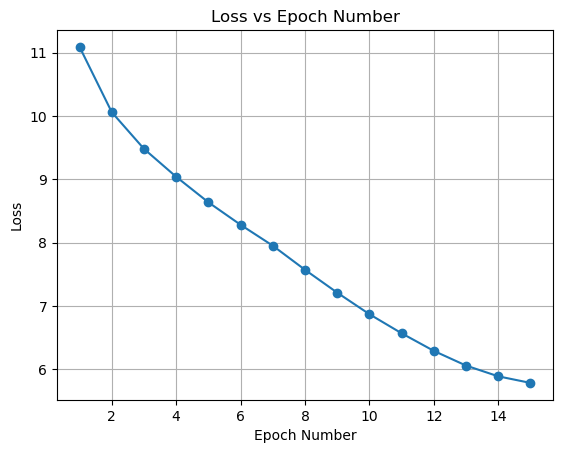

In [19]:
# Clearing memory before training
torch.cuda.empty_cache()

# Cosine based learning rate scheduler
base_lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=base_lr)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

model.train_model(train_loader, criterion, optimizer, num_epochs, device, proj_dir, scheduler=scheduler)

### Conducting Model Evaluation on Validation Set

In [20]:
# Model evaluation
val_dataset  = BooksDataset(val_set)
val_dataloader  = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False, collate_fn=partial(collate_fn, pad_token_id=pad_idx))

model.eval_model(test_dataloader = val_dataloader,
                  criterion = criterion,
                  device = device)

Model Evaluation: 100%|██████████| 5337/5337 [00:49<00:00, 106.81it/s]


Evaluation Loss: 12.0165, NDCG@10: 0.0598, MRR@10: 0.0530


{'avg_val_loss': 12.0164623391836,
 'NDCG@10': 0.05979255404173229,
 'MRR@10': 0.0530293254488729}

### Training for 20 Epochs

Starting training loop...


Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 104.98it/s]



Evaluation Loss: 4.8428, NDCG@10: 0.3811, MRR@10: 0.3417
Epoch [16/20], Average Loss: 5.7500, Learning Rate: 1e-06, NDCG@10: 0.3811, MRR: 0.3417
---



Model Evaluation: 100%|██████████| 5337/5337 [00:51<00:00, 104.61it/s]



Evaluation Loss: 4.8405, NDCG@10: 0.3814, MRR@10: 0.3419
Epoch [17/20], Average Loss: 5.7473, Learning Rate: 1e-06, NDCG@10: 0.3814, MRR: 0.3419
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 104.91it/s]



Evaluation Loss: 4.8392, NDCG@10: 0.3815, MRR@10: 0.3422
Epoch [18/20], Average Loss: 5.7479, Learning Rate: 1e-06, NDCG@10: 0.3815, MRR: 0.3422
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 104.85it/s]



Evaluation Loss: 4.8375, NDCG@10: 0.3819, MRR@10: 0.3425
Epoch [19/20], Average Loss: 5.7460, Learning Rate: 1e-06, NDCG@10: 0.3819, MRR: 0.3425
---



Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 105.07it/s]



Evaluation Loss: 4.8362, NDCG@10: 0.3819, MRR@10: 0.3425
Epoch [20/20], Average Loss: 5.7446, Learning Rate: 1e-06, NDCG@10: 0.3819, MRR: 0.3425
---

Checkpoint for Epoch 20 saved


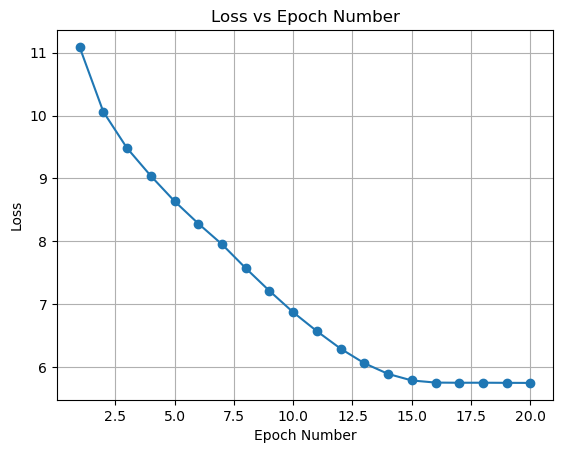

In [21]:
# Model training
num_epochs = 5
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

model.train_model(train_loader, criterion, optimizer, num_epochs, device, proj_dir, scheduler=scheduler)

### Conducting Model Evaluation on Validation Set

In [22]:
model.eval_model(test_dataloader = val_dataloader,
                  criterion = criterion,
                  device = device)

Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 106.18it/s]


Evaluation Loss: 12.0273, NDCG@10: 0.0599, MRR@10: 0.0531


{'avg_val_loss': 12.02732190492561,
 'NDCG@10': 0.05985065495702169,
 'MRR@10': 0.053104682866838525}

### Test Set Evaluation

In [23]:
test_dataset  = BooksDataset(test_set)
test_dataloader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, collate_fn=partial(collate_fn, pad_token_id=pad_idx))

model.eval_model(test_dataloader = test_dataloader,
                  criterion = criterion,
                  device = device)

Model Evaluation: 100%|██████████| 5337/5337 [00:50<00:00, 106.68it/s]


Evaluation Loss: 13.0786, NDCG@10: 0.0473, MRR@10: 0.0422


{'avg_val_loss': 13.078569845021251,
 'NDCG@10': 0.04733145436562302,
 'MRR@10': 0.04216412042613546}